In [9]:
import numpy as np

import random
import h5py
import theano.tensor as T
import theano
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re


# for reproducibility
np.random.seed(1337) 
random.seed(1337)

In [10]:
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

# Activation Functions and Derivatives

In [11]:
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [12]:
def activation_plot(fnc, xscl = 4.0, fnc_yscl = None, grd_yscl = None):
    plt.close('all')
    
    grd = T.grad(fnc, x)
    function = theano.function([x], fnc)
    gradient = theano.function([x], grd)
    
    x_vals = np.arange(-xscl, xscl, 0.001)
    
    plt.figure(figsize = (10, 4))

    plt.subplot(121)
    plt.title('function')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(-xscl, xscl)
    if (fnc_yscl):
        plt.ylim(fnc_yscl[0], fnc_yscl[1])
    plt.plot(x_vals, [function(i) for i in x_vals], '.', ms = 3)

    plt.subplot(122)
    plt.title('derivative')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(-xscl, xscl)
    if (grd_yscl):
        plt.ylim(grd_yscl[0], grd_yscl[1])
    plt.plot(x_vals, [gradient(i) for i in x_vals], '.', ms = 3)

    plt.show()
    
x = T.dscalar()

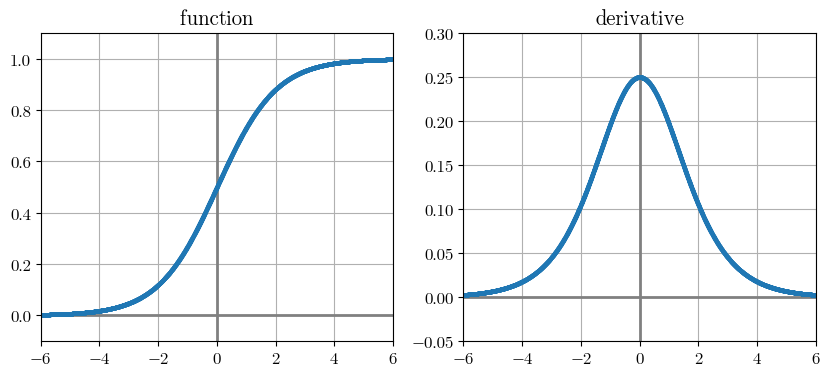

In [13]:
# sigmoid
fnc = 1 / (1 + T.exp(-x))
activation_plot(fnc, 6.0, (-0.1, 1.1), (-0.05, 0.3))

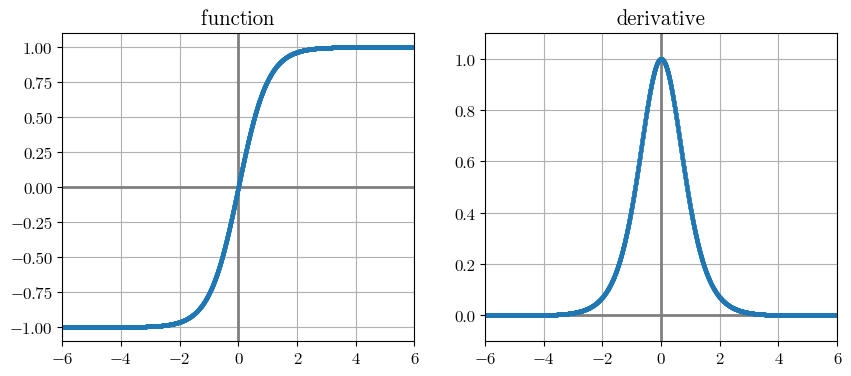

In [14]:
# tanh
fnc = T.tanh(x)
activation_plot(fnc, 6.0, (-1.1, 1.1), (-0.1, 1.1))

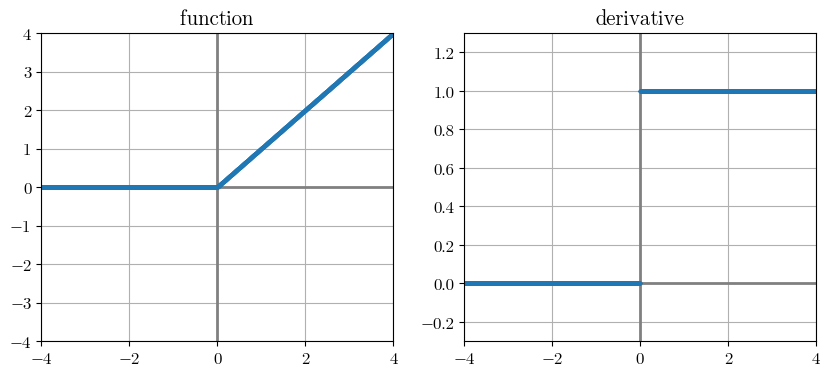

In [15]:
# ReLU
fnc = T.switch(x < 0, 0, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

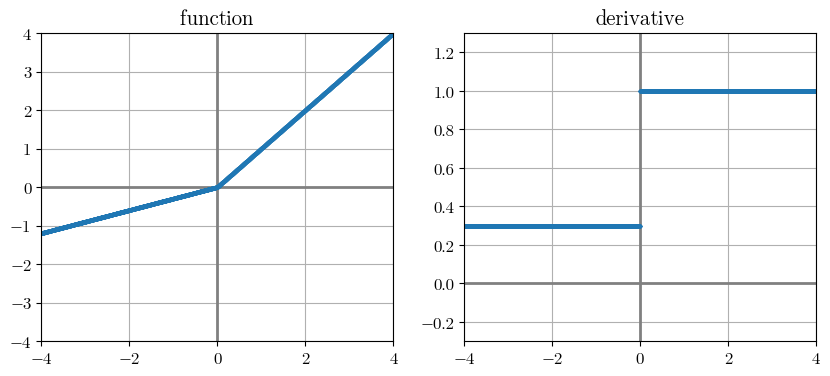

In [16]:
# Leaky ReLU
fnc = T.switch(x < 0, 0.3 * x, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

# Visualizing Softmax

In [ ]:
def numpy_softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

codebook = np.arange(0, 32)
to_quantize = np.array([3.24]).astype('float')

distances = np.abs(np.expand_dims(codebook, 0) - np.expand_dims(to_quantize, -1))
distances = distances[0]

print "TO QUANTIZE:", to_quantize

labels = tuple([str(i) for i in codebook])
y_pos = np.arange(len(labels))

plt.bar(y_pos, distances, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Distance')
plt.title('Codebook distance')
plt.show()

SOFTMAX_TEMP = 32.0
probs = numpy_softmax(SOFTMAX_TEMP * -distances)
plt.bar(y_pos, probs, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Probability')
plt.title('Codebook probabilities')
plt.show()
print "PROBS", probs

sparsity = np.sum(probs * np.log(probs + 1e-6), axis = -1)
sparsity = -np.mean(sparsity)
print "Sparsity score:", sparsity